In [2]:
pip install numba

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 2.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 1.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numba


In [7]:
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

In [81]:
N=50

In [82]:
init_random = np.random.random((N,N))
lattice_n = np.zeros((N,N))
lattice_n[init_random>=0.75]=1
lattice_n[init_random<=0.75]=-1

lattice_p = np.zeros((N,N))
lattice_p[init_random>=0.75]=-1
lattice_p[init_random<=0.75]=1

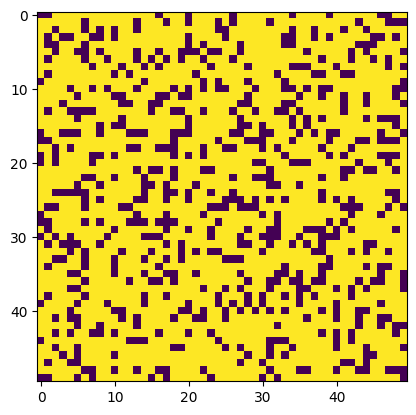

In [83]:
plt.imshow(lattice_p)

In [21]:
lattice_n

array([[ 1.,  1., -1., ..., -1., -1.,  1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [-1., -1.,  1., ..., -1., -1., -1.],
       ...,
       [-1.,  1., -1., ..., -1.,  1., -1.],
       [-1.,  1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ...,  1.,  1., -1.]])

In [84]:
kern=generate_binary_structure(2,2)
kern[1][1] = False
kern

array([[ True,  True,  True],
       [ True, False,  True],
       [ True,  True,  True]])

In [29]:
kern

array([[False,  True, False],
       [ True, False,  True],
       [False,  True, False]])

In [85]:
def get_energy(lattice):
    kern=generate_binary_structure(2,1)
    kern[1][1] = False
    arr = -lattice * convolve(lattice, kern, mode='constant', cval = 0)
    return arr.sum()

In [86]:
get_energy(lattice_p)

-2504.0

In [99]:
@numba.njit("UniTuple(f8[:],2)(f8[:,:], i8, f8, f8)" , nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0, times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y]
        spin_f = spin_i*-1

    
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]

        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]

        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]

        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
            
        dE=E_f-E_i
        if (dE>0)*(np.random.random()<np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y] = spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

In [106]:
spins, energies = metropolis(lattice_n, 10000000, 0.2, get_energy(lattice_n))

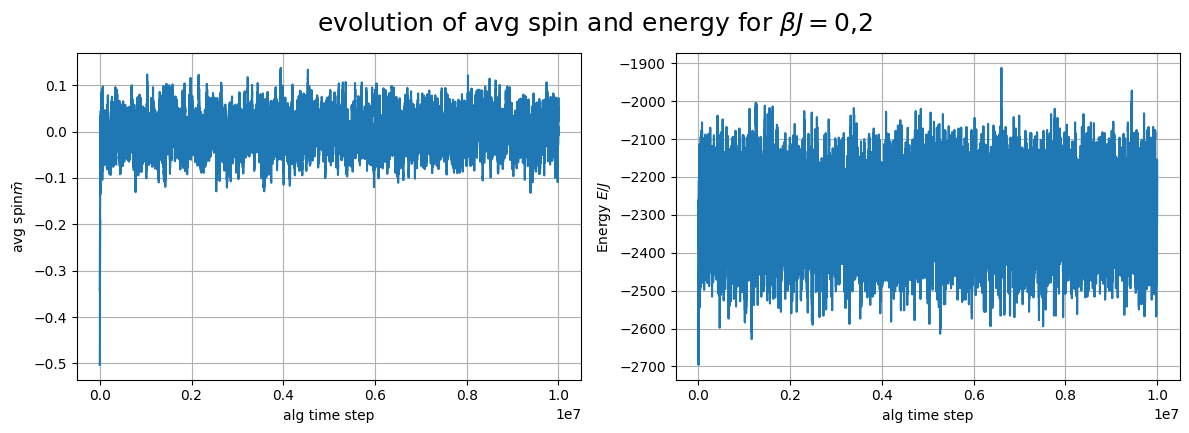

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
ax = axes[0]
ax.plot(spins/N**2)
ax.set_xlabel('alg time step')
ax.set_ylabel(r'avg spin$\bar{m}$')
ax.grid()
ax=axes[1]
ax.plot(energies)
ax.set_xlabel('alg time step')
ax.set_ylabel(r'Energy $E/J$')
ax.grid()
fig.tight_layout()
fig.suptitle(r'evolution of avg spin and energy for $\beta J=$0,2', y=1.07, size = 18)
plt.show()